
# **Deep-Learning Based Human Physical Activity Recognition with Wearable Sensor Data**

The following code implements gender recognition utilising wearable sensor data for multiple activities and sensor placements. This particular example utilises all the six measured signals (accelero x, y, z and gyro x, y, z) and applies end-to-end deep learning with 1D CNN, taking one sensor and activity combination at a time. 

Other approaches were also applied as part of the overall research, e.g., implementing the state-of-the-art model (autoencoders) instead of 1D CNN, or leaving out certain signal features in different directions, or leaving out gyroscope readings altogether, or fusing readings from multiple sensors for each activity via a multi-head 1D CNN.

## Import Libraries

In [ ]:
# Import Libraries
%matplotlib inline
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import scipy.io
import glob
from zipfile import ZipFile
from datetime import datetime
from collections import Counter
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling1D
from keras.layers import Input, Add, Permute, Reshape, multiply
from keras.layers import Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot, image
from scipy import stats
print(tf.__version__)

2.8.2


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/HAR Research Project/Datasets')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/HAR Research Project/Datasets


## Data Ingestion

In [ ]:
# Could convert to function
archive_1 = ZipFile('1.zip', 'r')
files_1 = archive_1.namelist()

archive_2 = ZipFile('2.zip', 'r')
files_2 = archive_2.namelist()

archive_3 = ZipFile('3.zip', 'r')
files_3 = archive_3.namelist()

archive_4 = ZipFile('4.zip', 'r')
files_4 = archive_4.namelist()

archive_5 = ZipFile('5.zip', 'r')
files_5 = archive_5.namelist()

archive_6 = ZipFile('6.zip', 'r')
files_6 = archive_6.namelist()

archive_7 = ZipFile('7.zip', 'r')
files_7 = archive_7.namelist()

dfs_1 = []
for file in files_1[1:]:  #skip .DS_Store
  frame = pd.read_csv(archive_1.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_1.append(frame)
df_1 = pd.concat(dfs_1,ignore_index=True)

dfs_2 = []
for file in files_2[1:]:
  frame = pd.read_csv(archive_2.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_2.append(frame)
df_2 = pd.concat(dfs_2,ignore_index=True)

dfs_3 = []
for file in files_3[1:]:
  frame = pd.read_csv(archive_3.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_3.append(frame)
df_3 = pd.concat(dfs_3,ignore_index=True)

dfs_4 = []
for file in files_4[1:]:
  frame = pd.read_csv(archive_4.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_4.append(frame)
df_4 = pd.concat(dfs_4,ignore_index=True)

dfs_5 = []
for file in files_5[1:]:
  frame = pd.read_csv(archive_5.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_5.append(frame)
df_5 = pd.concat(dfs_5,ignore_index=True)

dfs_6 = []
for file in files_6[1:]:
  frame = pd.read_csv(archive_6.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_6.append(frame)
df_6 = pd.concat(dfs_6,ignore_index=True)

dfs_7 = []
for file in files_7[1:]:
  frame = pd.read_csv(archive_7.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_7.append(frame)
df_7 = pd.concat(dfs_7,ignore_index=True)

pdList = [df_1, df_2, df_3, df_4, df_5, df_6, df_7] 
raw_df = pd.concat(pdList)

In [ ]:
gender_df = pd.read_csv('subject_chars_sheet1.csv')

## Data Pre-Processing

Note: The data is not fully complete for all subjects and trials

In [ ]:
full_df = raw_df.rename(columns={0: 'x_accelero', 1: 'y_accelero', 2: 'z_accelero', 3 : 'x_gyro', 4: 'y_gyro', 5: 'z_gyro'}, errors="raise")
full_df[['activity','subject_name', 'trial_number', 'timestamp', 'sensor_position']] = full_df['filename'].str.split('_',expand=True)
full_df[['sensor_position','file_type']] = full_df['sensor_position'].str.split('.',expand=True)
full_df.drop(columns=['filename', 'file_type'], inplace=True)

full_gd_df = full_df.merge(gender_df, on='subject_name', how='left')

full_gd_df['x_accelero'] = pd.to_numeric(full_gd_df['x_accelero'])
full_gd_df['y_accelero'] = pd.to_numeric(full_gd_df['y_accelero'])
full_gd_df['z_accelero'] = pd.to_numeric(full_gd_df['z_accelero'])
full_gd_df['x_gyro'] = pd.to_numeric(full_gd_df['x_gyro'])

full_gd_df['y_gyro'] = full_gd_df['y_gyro'].astype('string')
full_gd_df['y_gyro'] = full_gd_df['y_gyro'].apply(lambda x: x[:-2] if x[-2:] == ".1" else x)
full_gd_df['y_gyro'] = pd.to_numeric(full_gd_df['y_gyro'])

full_gd_df['z_gyro'] = full_gd_df['z_gyro'].astype('string')
full_gd_df['z_gyro'] = full_gd_df['z_gyro'].apply(lambda x: x[:-2] if x[-2:] == ".1" else x)
full_gd_df['z_gyro'] = pd.to_numeric(full_gd_df['z_gyro'])

full_gd_df['sensor_position'] = pd.to_numeric(full_gd_df['sensor_position'])
full_gd_df['activity'] = pd.to_numeric(full_gd_df['activity'])
full_gd_df['Gender Code'] = pd.to_numeric(full_gd_df['Gender Code'])

full_gd_df["Subject_Trial_Number"] = full_gd_df["subject_name"] + full_gd_df["trial_number"]

# This additional line drops subject records where the data is not given or is incomplete for all trials and sensors. 
# Unlike previous experiments where one subject_trial is left out for 1 sensor at a time, and rest are reshaped and computed, in this experiment sensors are used in parallel
# Leave one out returns the indices, therefore if data is missing for a parallel sensor the method would return an error
'''
full_gd_df = full_gd_df[(full_gd_df.subject_name != 'Cat') & (full_gd_df.subject_name != 'cheryl') & (full_gd_df.subject_name != 'drdang') & (full_gd_df.subject_name != 'gdil') & (full_gd_df.subject_name != 'thanh') & (full_gd_df.subject_name != 'tuong')]
full_gd_df = full_gd_df.reset_index(drop=True)
full_gd_df
'''
full_gd_df

,x_accelero,y_accelero,z_accelero,x_gyro,y_gyro,z_gyro,activity,subject_name,trial_number,timestamp,sensor_position,Age,Age Group,Gender,Gender Code,Weight,Height,BMI,Subject_Trial_Number
0,-0.995988,-9.761160,-0.081403,-1.251221,2.136230,0.091553,1,amala,1st,1567760697,1,45,3,Female,0,62.7,168.0,22.2,amala1st
1,-1.065420,-9.674969,-0.124498,-0.671387,0.579834,1.220703,1,amala,1st,1567760697,1,45,3,Female,0,62.7,168.0,22.2,amala1st
2,-1.065420,-9.732430,-0.167594,-1.678467,-0.610352,0.732422,1,amala,1st,1567760697,1,45,3,Female,0,62.7,168.0,22.2,amala1st
3,-1.079785,-9.758766,-0.102951,-1.159668,0.305176,0.183105,1,amala,1st,1567760697,1,45,3,Female,0,62.7,168.0,22.2,amala1st
4,-1.082179,-9.773131,-0.213084,-0.183105,0.000000,-0.152588,1,amala,1st,1567760697,1,45,3,Female,0,62.7,168.0,22.2,amala1st
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4582020,-0.217872,-9.279926,-1.654393,-2.685547,5.126953,-1.892090,7,van,3rd,1566546471,5,36,2,Male,1,79.0,173.0,26.4,van3rd
4582021,0.196325,-9.339781,-1.697489,-4.241943,-0.488281,-0.335693,7,van,3rd,1566546471,5,36,2,Male,1,79.0,173.0,26.4,van3rd
4582022,0.548272,-9.232042,-1.563414,-4.608154,-0.976562,2.197266,7,van,3rd,1566546471,5,36,2,Male,1,79.0,173.0,26.4,van3rd
4582023,0.591368,-9.188946,-1.699883,-4.943848,-0.061035,5.218506,7,van,3rd,1566546471,5,36,2,Male,1,79.0,173.0,26.4,van3rd


## Define Functions

### Reshaping Signal Sequences into Frames with the Sliding Window Method

In [ ]:
def get_frames(X, Y):
  
  N_FEATURES = 6

  frames = []
  labels = []

  # Returns frames of samples, each sample(group) with six features, each feature with n timesteps i.e. groups/samples * features * timesteps
  for Subject_Trial_Number_Encoded in set(X.Subject_Trial_Number_Encoded):  #for each group
    current_frame = X.loc[X.Subject_Trial_Number_Encoded == Subject_Trial_Number_Encoded]  #get the all the frames for that group
    start_index = min(current_frame.index)
    end_index = max(current_frame.index) + 1
    frame_size = len(current_frame)

    ax = X['x_accelero'].values[start_index: end_index] 
    ay = X['y_accelero'].values[start_index: end_index]
    az = X['z_accelero'].values[start_index: end_index]
    gx = X['x_gyro'].values[start_index: end_index] 
    gy = X['y_gyro'].values[start_index: end_index]
    gz = X['z_gyro'].values[start_index: end_index]

    # Retrieve the most often used label in this segment
    label = stats.mode(Y[start_index: end_index])[0][0]
    
    frames.append([ax, ay, az, gx, gy, gz])
    labels.append(label)

  # As the frame size differs for each group, the frames are padded. 
  # Returns exactly the same shape as above but padded so each group has same number of steps
  padded_frames = []
  for row in frames:
    shape = np.shape(row)
    padded_array = np.zeros((6, 3000)) # 3000 is max number of steps for any group
    padded_array[:shape[0],:shape[1]] = row
    padded_frames.append(padded_array)

  # Bring the segments into a better shape i.e. converts the  groups/samples * features * timesteps  ->  groups/samples * timestep * features
  reshaped_padded_frames = np.transpose(padded_frames, (0, 2, 1))
  reshaped_labels = np.asarray(labels)
  
  return reshaped_padded_frames, reshaped_labels

### Learning Rate Scheduler

In [ ]:
# This function keeps the initial learning rate for the first ten epochs and decreases it exponentially after that
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # call learning rate scheduler

### CNN Model

In [ ]:
def cnn_model_creation(n_timesteps, n_features):
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
  model.add(BatchNormalization())
  model.add(GlobalAveragePooling1D())
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', 
                 optimizer='Adam',
                 metrics=['accuracy'])
    
  return model

### State-of-the-Art Model - not utilised as CNN returns better performance

In [ ]:
def squeeze_excite_block(inputs):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    filters = inputs.shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(inputs)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([inputs, se])
    return se

def SOTA_model_creation_(n_timesteps, n_features):
    input_ = Input(shape=(n_timesteps, n_features))

    # RNN
    r_layer1 = LSTM(8)(input_)

    # CNN
    c_layer1 = Conv1D(64, 8, activation='relu', padding='same')(input_)
    c_layer1 = BatchNormalization()(c_layer1)
    c_layer1 = squeeze_excite_block(c_layer1)

    c_layer2 = Conv1D(128, 5, activation='relu', padding='same')(c_layer1)
    c_layer2 = BatchNormalization()(c_layer2)
    c_layer2 = squeeze_excite_block(c_layer2)

    c_layer3 = Conv1D(64, 3, activation='relu', padding='same')(c_layer2)
    c_layer3 = BatchNormalization()(c_layer3)

    c_pool = GlobalAveragePooling1D()(c_layer3)

    merge = Concatenate()([r_layer1, c_pool])
    output = Dense(1, activation='sigmoid')(merge)
    model = Model(inputs=[input_], outputs=output)

    model.compile(loss='binary_crossentropy', 
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, class_names):
    '''
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    '''
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

### Training the Model

In [ ]:
def get_scores(sensor_position_number, activity_number, full_gd_df): 
   
    # Drop unrequired columns
    partial_df = full_gd_df.drop(columns=['subject_name', 'trial_number','timestamp', 'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI'])
    
    # Encode the Subject_Trial_Number
    le = preprocessing.LabelEncoder()
    partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
    partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
    
    # Extract data for specified sensor and activity
    # partial_df = partial_df[partial_df["sensor_position"] == 1]
    partial_df = partial_df[partial_df["sensor_position"] == sensor_position_number]
    # partial_df = partial_df[partial_df["activity"] == 1]
    partial_df = partial_df[partial_df["activity"] == activity_number]
    partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) # this resets index each time for different sensor and activity combinations

    # Standardise the sensor readings
    scaler = StandardScaler()
    partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

    # Partition Train+Val (i.e. partial_df_train) and Test Data (i.e. partial_df_test)
    partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) 
    partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

    # Define Train X and y variables
    X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
    y_TRAIN = partial_df_train['Gender Code']
    X_TRAIN = X_TRAIN.to_numpy() # for LOGO
    y_TRAIN = y_TRAIN.to_numpy() # for LOGO

    # Define Test X and y variables
    X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
    y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

    # Convert Test data to frames
    reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) 
    
    # Obtain groups for LOGO
    groups = partial_df_train['Subject_Trial_Number_Encoded']
    logo = LeaveOneGroupOut()
    split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
    groups = groups.to_numpy()

    # Initialise lists
    acc_per_fold = []
    loss_per_fold = []
    train_acc_per_fold = []
    train_loss_per_fold = []
    val_acc_per_fold = []
    val_loss_per_fold = []
    cm_holder_per_fold = []	
    y_true, y_pred, y_pred_prob = list(), list(),list()

    # Train model with leave-one-group-out cross validation
    for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
      # Split data for training and validation
      X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
      y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 
      
      X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train = pd.DataFrame(data = y_train)
      y_val = pd.DataFrame(data = y_val) 

      # Convert train and validation data to frames
      reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
      reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 
      
      # Define input variables
      n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

      # Obtain the model
      model = cnn_model_creation(n_timesteps, n_features)

      # Save model summary
      model.summary()
      plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)  
      
      # Train model
      history = model.fit(reshaped_X_train, reshaped_y_train,
                epochs=50,
                verbose=0,
                callbacks=[lr_callback],
                validation_data=(reshaped_X_val, reshaped_y_val)) 
      
      # Evaluate on Test data
      test_scores = model.evaluate(reshaped_X_test,reshaped_y_test, verbose=0)
      acc_per_fold.append(test_scores[1] * 100)
      loss_per_fold.append(test_scores[0])

      # For plotting the Confusion Matrix
      ## Utilise the model to predict the values from the test data.	
      predictions_ = model.predict(reshaped_X_test)	

      ## Select the class with the highest probability from the test predictions	
      predictions = np.where(predictions_ > 0.5, 1, 0)	

      ## Calculate the confusion matrix using sklearn.metrics	
      cm = metrics.confusion_matrix(reshaped_y_test, predictions)	

      ## Append the confusion matrix of this fold	
      cm_holder_per_fold.append(cm)	

      ## Store the ground truth and predicted values	
      y_true.append(reshaped_y_test) 
      y_pred.append(predictions) 	
      y_pred_prob.append(predictions_)	

    # Evaluation metrics across all folds
    mean_accuracy = np.mean(acc_per_fold)
    mean_std = np.std(acc_per_fold)
    mean_loss = np.mean(loss_per_fold)
    print('Sensor:', sensor_position_number, 'Activity:', activity_number)
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')

    # Confusion matrix across all folds
    class_names = ['0', '1']	
    sum_cm_holder_per_fold = []	
    cm_shape = np.array([len(class_names),len(class_names)])	
    for k in range(len(cm_holder_per_fold)):	
        cm_mask = np.zeros(cm_shape)	
        cm_mask[:cm_holder_per_fold[k].shape[0], :cm_holder_per_fold[k].shape[1]] = cm_holder_per_fold[k]	
        sum_cm_holder_per_fold.append(cm_mask)	
    sum_cm_per_fold = sum(sum_cm_holder_per_fold)	
    figure = plot_confusion_matrix(sum_cm_per_fold, class_names=class_names)	
    plt.show()  
    return mean_accuracy

## Call the train function for different sensor/activity combinations and obtain the results

In [ ]:
test_scores = []
activity_list = [1, 2, 3, 4, 5, 6, 7]
sensor_list = [1, 2, 3, 4, 5]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, full_gd_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores # (hadnt returned mean_accuracy while running thats why test_scores appends a none var)

## Plot the Training and Validation Loss and Accuracy Graphs

In [ ]:
# Plot the training and validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Plot the ROC-AUC Graphs

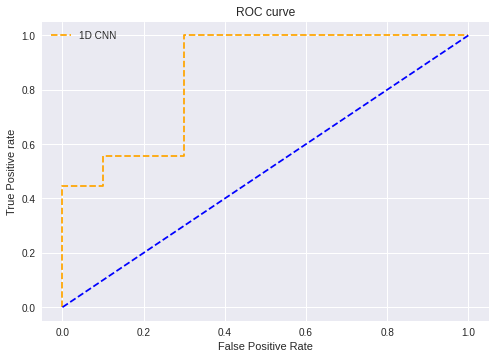

In [ ]:
from sklearn.metrics import roc_curve
fpr1, tpr1, thresh1 = roc_curve(reshaped_y_test, predictions_, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(reshaped_y_test))]
p_fpr, p_tpr, _ = roc_curve(reshaped_y_test, random_probs, pos_label=1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='1D CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(reshaped_y_test, predictions)
auc_score1

0.85